<a href="https://colab.research.google.com/github/harshithap99/Hand_drawn_Sketch_recognition/blob/main/Scratch_Sketch_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np 
import pandas as pd 
import keras 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import glob
from sklearn.datasets import load_files
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.utils import np_utils
from sklearn.model_selection import  train_test_split

In [3]:
img=glob.glob(("/content/drive/My Drive/sketch_80/*"))
for i in img:
    print(i)

/content/drive/My Drive/sketch_80/axe
/content/drive/My Drive/sketch_80/angel
/content/drive/My Drive/sketch_80/armchair
/content/drive/My Drive/sketch_80/backpack
/content/drive/My Drive/sketch_80/arm
/content/drive/My Drive/sketch_80/apple
/content/drive/My Drive/sketch_80/alarm clock
/content/drive/My Drive/sketch_80/ashtray
/content/drive/My Drive/sketch_80/ant
/content/drive/My Drive/sketch_80/airplane
/content/drive/My Drive/sketch_80/cannon
/content/drive/My Drive/sketch_80/camera
/content/drive/My Drive/sketch_80/castle
/content/drive/My Drive/sketch_80/candle
/content/drive/My Drive/sketch_80/camel
/content/drive/My Drive/sketch_80/canoe
/content/drive/My Drive/sketch_80/cell phone
/content/drive/My Drive/sketch_80/car (sedan)
/content/drive/My Drive/sketch_80/carrot
/content/drive/My Drive/sketch_80/cat
/content/drive/My Drive/sketch_80/cake
/content/drive/My Drive/sketch_80/bush
/content/drive/My Drive/sketch_80/butterfly
/content/drive/My Drive/sketch_80/bread
/content/driv

In [4]:
dir = '/content/drive/My Drive/sketch_80'
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x, y,target_labels = load_dataset(dir)
print('Loading complete!')
print('Training set size : ' , x.shape[0])

Loading complete!
Training set size :  4000


In [5]:
no_of_classes = len(np.unique(y))
print(target_labels)
print(no_of_classes)
#print(y)
y= np_utils.to_categorical(y,no_of_classes)

['airplane' 'alarm clock' 'angel' 'ant' 'apple' 'arm' 'armchair' 'ashtray'
 'axe' 'backpack' 'banana' 'barn' 'baseball bat' 'basket' 'bathtub'
 'bear (animal)' 'bed' 'bee' 'beer-mug' 'bell' 'bench' 'bicycle'
 'binoculars' 'blimp' 'book' 'bookshelf' 'boomerang' 'bottle opener'
 'bowl' 'brain' 'bread' 'bridge' 'bulldozer' 'bus' 'bush' 'butterfly'
 'cabinet' 'cactus' 'cake' 'calculator' 'camel' 'camera' 'candle' 'cannon'
 'canoe' 'car (sedan)' 'carrot' 'castle' 'cat' 'cell phone']
50


In [6]:
#dividing the entire dataset into training data and validation data
X_train,x_val,Y_train,y_val = train_test_split(x,y,test_size=0.18,random_state=42)
#dividing the training dataset into training and testing
X_train,x_test,Y_train,y_test = train_test_split(X_train,Y_train,test_size=0.22,random_state=42)
X_train.shape,Y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape
# sum should result in total
print(len(X_train))
print(len(x_val))
print(len(x_test))

2558
720
722


In [7]:
default_image_size=tuple((256,256))
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
         # Convert to Numpy Array
        image=cv2.imread(file)
        if image is not None :
          image=cv2.resize(image, default_image_size) 
          images_as_array.append(img_to_array(image))
    return images_as_array

X_train = np.array(convert_image_to_array(X_train))
x_val = np.array(convert_image_to_array(x_val))
x_test = np.array(convert_image_to_array(x_test))
print('Validation set shape : ',x_val.shape)
print('Training set shape : ',X_train.shape)
print('Test set shape : ',x_test.shape)

Validation set shape :  (720, 256, 256, 3)
Training set shape :  (2558, 256, 256, 3)
Test set shape :  (722, 256, 256, 3)


In [8]:
# time to re-scale so that all the pixel values lie within 0 to 1
X_train = X_train.astype('float32')/255
x_val = x_val.astype('float32')/255
x_test = x_test.astype('float32')/255

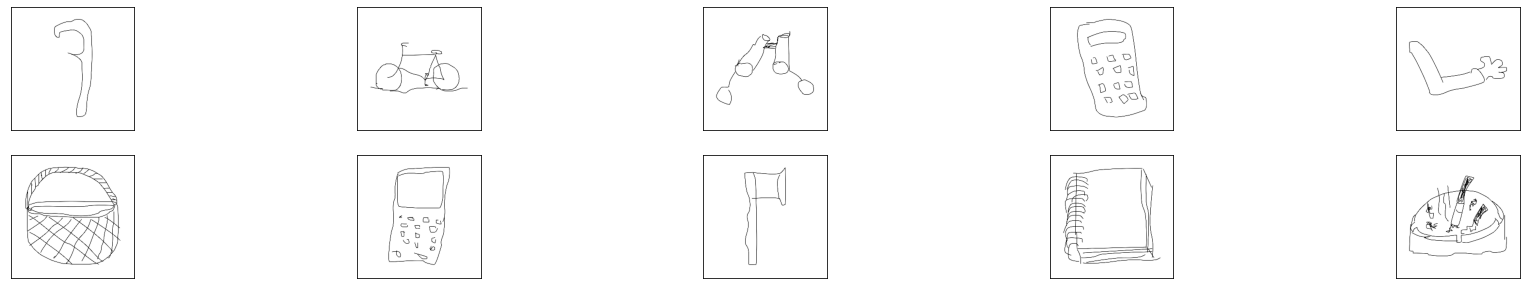

In [9]:
#Let's visualize the first 10 training images!
fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

In [10]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(256,256,3)))
model.add(MaxPool2D((2, 2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2, 2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2, 2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(no_of_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       5

In [11]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])

In [12]:
imagegen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                            rotation_range=60,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              fill_mode='reflect')
imagegen.fit(X_train)

In [20]:

from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
#batch_size = 32

checkpoint = ModelCheckpoint(filepath = 'cnn3.hdf5',monitor='val_accuracy' ,verbose = 1, save_best_only = True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,mode='auto')
#checkpointer = ModelCheckpoint('cnn.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
history = model.fit_generator(
        imagegen.flow(X_train,Y_train,batch_size=32),
        #steps_per_epoch=80,
        epochs=30,
        validation_data=imagegen.flow(x_val, y_val,batch_size=32),
        #validation_steps=50,
        callbacks=[checkpoint,reduce_lr],
        verbose=2, 
        shuffle=True
        )
#checkpoint = ModelCheckpoint(filepath = 'cnn3.hdf5',monitor='val_accuracy' ,verbose = 1, save_best_only = True)
#model_dropout = model.fit_generator(imagegen.flow(X_train,Y_train, batch_size=64),epochs=100,verbose=2,
 #                         validation_data=(x_val, y_val),steps_per_epoch=X_train.shape[0] // 64,callbacks=[checkpoint],shuffle=True)

Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.03750, saving model to cnn3.hdf5
80/80 - 100s - loss: 1.5720 - accuracy: 0.5516 - val_loss: 198.4321 - val_accuracy: 0.0375
Epoch 2/30

Epoch 00002: val_accuracy did not improve from 0.03750
80/80 - 49s - loss: 1.6889 - accuracy: 0.5145 - val_loss: 165.3407 - val_accuracy: 0.0139
Epoch 3/30

Epoch 00003: val_accuracy did not improve from 0.03750
80/80 - 48s - loss: 1.7552 - accuracy: 0.4957 - val_loss: 20484.7109 - val_accuracy: 0.0306
Epoch 4/30

Epoch 00004: val_accuracy improved from 0.03750 to 0.04861, saving model to cnn3.hdf5
80/80 - 99s - loss: 1.7213 - accuracy: 0.5172 - val_loss: 34.7462 - val_accuracy: 0.0486
Epoch 5/30

Epoch 00005: val_accuracy did not improve from 0.04861
80/80 - 48s - loss: 1.7843 - accuracy: 0.5008 - val_loss: 1554.7776 - val_accuracy: 0.0208
Epoch 6/30

Epoch 00006: val_accuracy did not improve from 0.04861
80/80 - 47s - loss: 1.7648 - accuracy: 0.5070 - val_loss: 1026.8027 - val_accuracy: 0.

In [21]:
test_eval = model.evaluate(x_test, y_test, verbose=2)

23/23 - 1s - loss: 4.1688 - accuracy: 0.4598


In [22]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1).astype(int)
y_true = np.argmax(y_test,axis = 1).astype(int)

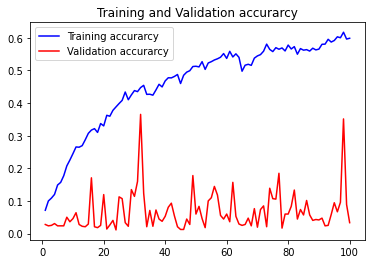

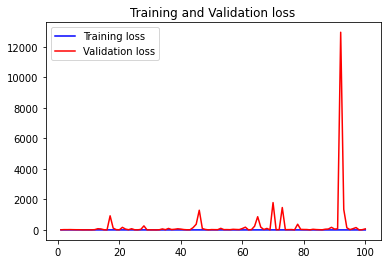

In [24]:
acc = model_dropout.history['accuracy']
val_acc = model_dropout.history['val_accuracy']
loss = model_dropout.history['loss']
val_loss = model_dropout.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [25]:
corr=[]
incorr=[]
corr_count=0
incorr_count=0

for i in range(len(y_test)):
    if(y_pred[i]==y_true[i]):
        corr.append(i)
        corr_count+=1
    else:
        incorr.append(i)
        incorr_count+=1
        
print("Found %d correct" %(corr_count))
print("Found %d incorrect " %(incorr_count))

Found 332 correct
Found 390 incorrect 


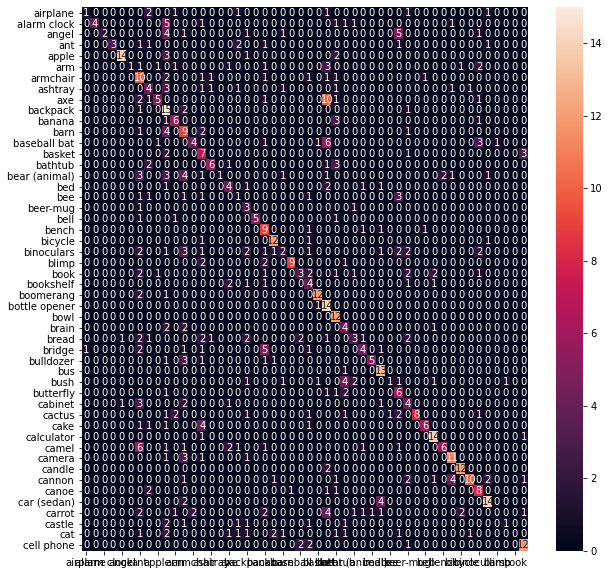

In [26]:
y_pred=model.predict(x_val)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
#plot the con mat
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(np.unique(target_labels))
ax.set_yticklabels(np.unique(target_labels))
plt.show()

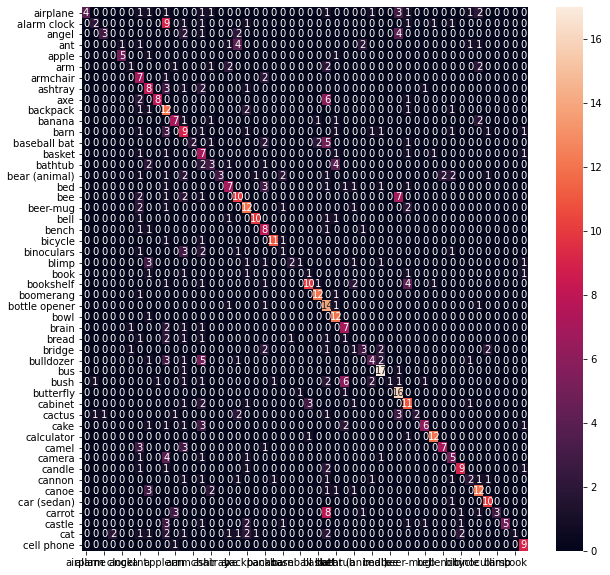

In [27]:
y_pred=model.predict(x_test)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(np.unique(target_labels))
ax.set_yticklabels(np.unique(target_labels))
plt.show()